In [ ]:
import sys

sys.path.insert(0, "../..")

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from typing import Dict, Optional, Tuple
from tqdm import tqdm
import json

## Generate seeds for different experiments

In [ ]:
from src.seeds import generate_seeds

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 4)

SEEDS = {
    "main": 42,
    "grid_search": generate_seeds(),
    "evaluation": generate_seeds(),
    "steady_state": generate_seeds(),
}

print("🎲 Seeds initialized:")
for name, seed in SEEDS.items():
    print(f"  {name}: {seed}")

## Part 1: What is (s,S) Policy?

### The Rule:
```
IF inventory_position ≤ s:
    order (S - inventory_position) units
ELSE:
    don't order
```

### Parameters:
- **s**: Reorder point - WHEN to order
- **S**: Order-up-to level - target inventory position after ordering

### Key Formula:
**Inventory Position (IP)** = Net_Inventory + Outstanding_Orders

>note: (net_inventory = on_hand - backorders)

In [2]:
from src.mdp import create_state

# Policy parameters
s = 10  # Reorder point
S = 25  # Order-up-to level

print(f"Policy: (s={s}, S={S})")
print(f"\nRule: If IP ≤ {s}, order (S - IP) units")
print("\nExamples:")

# Example 1: High inventory position
state1 = create_state(20, 20, 0, 0)
ip1 = state1.get_inventory_position(0)
print(f"\n1. IP={ip1}")
if ip1 <= s:
    order = S - ip1
    print(f"   → ORDER {order} units (bring IP to {S})")
else:
    print(f"   → DON'T ORDER (IP > {s})")

# Example 2: At reorder point
state2 = create_state(10, 10, 0, 0)
ip2 = state2.get_inventory_position(0)
print(f"\n2. IP={ip2}")
if ip2 <= s:
    order = S - ip2
    print(f"   → ORDER {order} units (bring IP to {S})")
else:
    print(f"   → DON'T ORDER (IP > {s})")

# Example 3: Below reorder point
state3 = create_state(5, 5, 0, 0)
ip3 = state3.get_inventory_position(0)
print(f"\n3. IP={ip3}")
if ip3 <= s:
    order = S - ip3
    print(f"   → ORDER {order} units (bring IP to {S})")
else:
    print(f"   → DON'T ORDER (IP > {s})")

# Example 4: Stockout with outstanding order
state4 = create_state(-5, -5, 10, 10)
ip4 = state4.get_inventory_position(0)
print(f"\n4. Net_inv=-5 (backorders), Outstanding=10 → IP={ip4}")
if ip4 <= s:
    order = S - ip4
    print(f"   → ORDER {order} units (bring IP to {S})")
else:
    print(f"   → DON'T ORDER (IP > {s})")

print("\n💡 Policy orders exact amount needed to reach S")

Policy: (s=10, S=25)

Rule: If IP ≤ 10, order (S - IP) units

Examples:

1. IP=20
   → DON'T ORDER (IP > 10)

2. IP=10
   → ORDER 15 units (bring IP to 25)

3. IP=5
   → ORDER 20 units (bring IP to 25)

4. Net_inv=-5 (backorders), Outstanding=10 → IP=5
   → ORDER 20 units (bring IP to 25)

💡 Policy orders exact amount needed to reach S


## Part 2: Visualize (s,S) Decision Rule

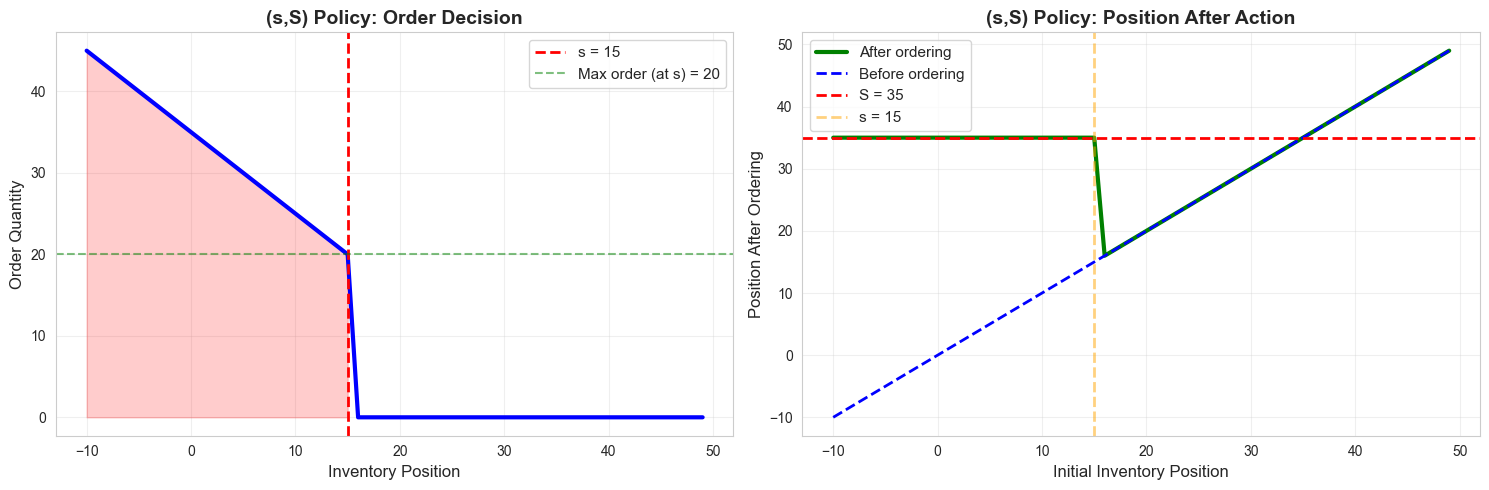


✓ Key observations:
   - Below s: Order to bring position exactly to S
   - Above s: Don't order
   - Creates 'acceptable band' [16, 35]
   - Order size varies from 1 to 20 depending on IP


In [3]:
# Simulate policy for different inventory positions
s_viz = 15
S_viz = 35

positions = np.arange(-10, 50, 1)
orders = []

for pos in positions:
    if pos <= s_viz:
        orders.append(S_viz - pos)
    else:
        orders.append(0)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Order quantity vs position
axes[0].plot(positions, orders, linewidth=3, color="blue")
axes[0].axvline(s_viz, color="red", linestyle="--", linewidth=2, label=f"s = {s_viz}")
axes[0].axhline(
    S_viz - s_viz,
    color="green",
    linestyle="--",
    alpha=0.5,
    label=f"Max order (at s) = {S_viz-s_viz}",
)
axes[0].fill_between(
    positions, 0, orders, where=(positions <= s_viz), alpha=0.2, color="red"
)
axes[0].set_xlabel("Inventory Position", fontsize=12)
axes[0].set_ylabel("Order Quantity", fontsize=12)
axes[0].set_title("(s,S) Policy: Order Decision", fontsize=14, fontweight="bold")
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Position after ordering
position_after = [pos + order for pos, order in zip(positions, orders)]
axes[1].plot(
    positions, position_after, linewidth=3, color="green", label="After ordering"
)
axes[1].plot(
    positions,
    positions,
    linewidth=2,
    linestyle="--",
    color="blue",
    label="Before ordering",
)
axes[1].axhline(S_viz, color="red", linestyle="--", linewidth=2, label=f"S = {S_viz}")
axes[1].axvline(
    s_viz, color="orange", linestyle="--", linewidth=2, alpha=0.5, label=f"s = {s_viz}"
)
axes[1].set_xlabel("Initial Inventory Position", fontsize=12)
axes[1].set_ylabel("Position After Ordering", fontsize=12)
axes[1].set_title("(s,S) Policy: Position After Action", fontsize=14, fontweight="bold")
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Key observations:")
print("   - Below s: Order to bring position exactly to S")
print("   - Above s: Don't order")
print(f"   - Creates 'acceptable band' [{s_viz+1}, {S_viz}]")
print(f"   - Order size varies from 1 to {S_viz - s_viz} depending on IP")

## Part 3: Empirical Optimization Approach

**Method: Grid Search**
1. Define search ranges for (s, S) parameters
2. Test each combination via simulation
3. Evaluate performance (total reward over episodes)
4. Select best policy

**Then determine Q_max** for RL agent based on best policy's order sizes

In [ ]:
from typing import Any
from src.simulation import InventorySimulation
from src.baseline import sSPolicy, create_sS_policy
from src.mdp import create_state, RewardFunction


def evaluate_policy(
    policy: sSPolicy,
    num_episodes: int,
    episode_length: int,
    initial_state: Optional[Tuple[int, int, int, int]] = None,
    random_seed: Optional[int] = None,
) -> Dict[str, Any]:
    """
    Evaluate a policy by running multiple episodes using InventorySimulation directly.

    Args:
        policy: The (s,S) policy to evaluate
        num_episodes: Number of evaluation episodes
        episode_length: Steps per episode
        initial_state: Fixed initial state (net_inv_0, net_inv_1, out_0, out_1) or None for empty
        random_seed: Random seed for reproducibility

    Returns:
        Dictionary with mean reward, std, and max order sizes observed
    """
    # Create master RNG for this evaluation
    master_rng = np.random.default_rng(random_seed)

    reward_fn = RewardFunction()

    episode_rewards = []
    max_orders = [0, 0]  # Track max order size for each product

    for _ in range(num_episodes):
        # Create episode-specific RNG (derived from master RNG)
        episode_rng = np.random.default_rng(master_rng.integers(0, 2**31))
        sim = InventorySimulation(random_state=episode_rng)

        # Reset to initial state
        if initial_state is not None:
            ni0, ni1, oo0, oo1 = initial_state
            init_state = create_state(ni0, ni1, oo0, oo1)
        else:
            init_state = create_state(0, 0, 0, 0)  # Empty state

        sim.reset(initial_state=init_state)

        total_reward = 0

        for _ in range(episode_length):
            current_state = sim.get_current_state()

            action = policy(current_state)

            # Track max orders
            for i in range(2):
                max_orders[i] = max(max_orders[i], action.order_quantities[i])

            next_state, _ = sim.execute_daily_decision(action)

            reward = reward_fn(next_state, action)
            total_reward += reward

        episode_rewards.append(total_reward)

    return {
        "mean_reward": np.mean(episode_rewards),
        "std_reward": np.std(episode_rewards),
        "max_order_0": max_orders[0],
        "max_order_1": max_orders[1],
        "rewards": episode_rewards,
    }


print("✓ Evaluation function ready (with proper RNG management)")

✓ Evaluation function ready


## Part 4: Determine Search Ranges

Before grid search, we need to determine reasonable ranges for (s, S):

### Theoretical Guidance for Range Selection:

**Reorder point (s)**:
- Lower bound: ~50% of DDLT (very aggressive, high risk)
- Upper bound: ~200% of DDLT (very conservative, high inventory)
- **DDLT** (Demand During Lead Time) ≈ daily_demand_rate × lead_time

**Order-up-to level (S)**:
- Should be S = s + order_size
- Order size range: From ~DDLT (frequent orders) to ~2-3× DDLT (bulk orders)

In [5]:
from src.simulation import create_default_products

# Get system parameters
product_0, product_1 = create_default_products()

# Calculate DDLT for each product
arrival_rate = 1.0 / 3.0  # customers per day (from assignment)

daily_demand_0 = arrival_rate * product_0.expected_demand
daily_demand_1 = arrival_rate * product_1.expected_demand

ddlt_0 = daily_demand_0 * product_0.expected_lead_time
ddlt_1 = daily_demand_1 * product_1.expected_lead_time

print("=" * 70)
print("SYSTEM ANALYSIS FOR SEARCH RANGE DETERMINATION")
print("=" * 70)

print(f"\n📦 Product 0:")
print(f"  Daily demand rate: {daily_demand_0:.3f} units/day")
print(f"  Expected lead time: {product_0.expected_lead_time:.1f} days")
print(f"  DDLT: {ddlt_0:.2f} units")

print(f"\n📦 Product 1:")
print(f"  Daily demand rate: {daily_demand_1:.3f} units/day")
print(f"  Expected lead time: {product_1.expected_lead_time:.1f} days")
print(f"  DDLT: {ddlt_1:.2f} units")

# Determine search ranges
s_min = int(max(ddlt_0, ddlt_1) * 0.5)  # 50% of DDLT (aggressive)
s_max = int(max(ddlt_0, ddlt_1) * 2.0)  # 200% of DDLT (conservative)

order_size_min = int(max(ddlt_0, ddlt_1) * 0.8)  # Small orders
order_size_max = int(max(ddlt_0, ddlt_1) * 2.5)  # Large orders

print(f"\n🎯 Recommended Search Ranges:")
print(f"  Reorder point (s): [{s_min}, {s_max}]")
print(f"  Order size (S-s): [{order_size_min}, {order_size_max}]")
print(f"  Rationale:")
print(f"    - s covers 50%-200% of DDLT")
print(f"    - S-s covers 80%-250% of DDLT")
print(
    f"    - Total combinations: {(s_max-s_min+1)**2 * (order_size_max-order_size_min+1)**2}"
)

print("=" * 70)

SYSTEM ANALYSIS FOR SEARCH RANGE DETERMINATION

📦 Product 0:
  Daily demand rate: 0.833 units/day
  Expected lead time: 22.5 days
  DDLT: 18.75 units

📦 Product 1:
  Daily demand rate: 1.208 units/day
  Expected lead time: 13.5 days
  DDLT: 16.31 units

🎯 Recommended Search Ranges:
  Reorder point (s): [9, 37]
  Order size (S-s): [15, 46]
  Rationale:
    - s covers 50%-200% of DDLT
    - S-s covers 80%-250% of DDLT
    - Total combinations: 861184


In [ ]:
from itertools import product


def grid_search_policy(
    s_range: Tuple[int, int],
    S_offset_range: Tuple[int, int],
    num_episodes: int,
    episode_length: int,
    random_seed: int,
    initial_state: Optional[Tuple[int, int, int, int]] = None,
) -> pd.DataFrame:
    """
    Grid search over (s,S) parameters for both products using itertools.product.

    Args:
        s_range: (min, max) for reorder point
        S_offset_range: (min, max) for S-s (order quantity range)
        num_episodes: Episodes per policy evaluation
        episode_length: Steps per episode
        random_seed: Random seed
        initial_state: Fixed initial state or None for empty (0,0,0,0)

    Returns:
        DataFrame with results sorted by mean reward
    """
    results = []

    # Generate parameter ranges
    s_values = range(s_range[0], s_range[1] + 1)
    offset_values = range(S_offset_range[0], S_offset_range[1] + 1)

    # Use itertools.product for Cartesian product
    all_combinations = list(product(s_values, s_values, offset_values, offset_values))
    total_combinations = len(all_combinations)

    print(f"Testing {total_combinations} policy combinations...")
    print(f"  s₀, s₁ ∈ {s_range}")
    print(f"  S - s ∈ {S_offset_range}")
    print(f"  Each policy: {num_episodes} episodes × {episode_length} steps")
    print(f"  Random seed: {random_seed}")
    print()

    # Progress bar
    for s0, s1, offset0, offset1 in tqdm(all_combinations, desc="Grid search"):
        S0 = s0 + offset0
        S1 = s1 + offset1

        # Create and evaluate policy
        policy = create_sS_policy((s0, S0), (s1, S1))

        try:
            eval_results = evaluate_policy(
                policy,
                num_episodes=num_episodes,
                episode_length=episode_length,
                initial_state=initial_state,
                random_seed=random_seed,
            )

            results.append(
                {
                    "s0": s0,
                    "S0": S0,
                    "s1": s1,
                    "S1": S1,
                    "order_size_0": S0 - s0,
                    "order_size_1": S1 - s1,
                    "max_order_0": eval_results["max_order_0"],
                    "max_order_1": eval_results["max_order_1"],
                    "mean_reward": eval_results["mean_reward"],
                    "std_reward": eval_results["std_reward"],
                }
            )
        except Exception as e:
            print(f"\nError evaluating ({s0},{S0}), ({s1},{S1}): {e}")

    # Convert to DataFrame and sort
    df = pd.DataFrame(results)
    if len(df) > 0:
        df = df.sort_values("mean_reward", ascending=False)

    return df

## Part 6: Full Grid Search

Run comprehensive search over the data-driven parameter ranges.

In [ ]:
# Full grid search with data-driven ranges
print("=" * 70)
print("FULL GRID SEARCH")
print("=" * 70)

full_results = grid_search_policy(
    s_range=(s_min, s_max),  # Data-driven from DDLT analysis
    S_offset_range=(order_size_min, order_size_max),  # Data-driven order sizes
    num_episodes=10,  # Moderate number for quicker results
    episode_length=365,  # 1 year
    initial_state=None,  # Start from empty (0,0,0,0)
    random_seed=SEEDS["grid_search"],  # Use dedicated seed for grid search
)

# Save results
full_results.to_csv("../../results/policy_grid_search.csv", index=False)
print(f"\n✓ Results saved to results/policy_grid_search.csv")

# Display top 10
print("\n" + "=" * 70)
print("TOP 10 POLICIES (by mean reward)")
print("=" * 70)
print(full_results.head(10).to_string(index=False))

# Best policy
best = full_results.iloc[0]
print("\n" + "=" * 70)
print("🏆 BEST POLICY")
print("=" * 70)
print(
    f"  Product 0: (s={int(best['s0'])}, S={int(best['S0'])}) → typical order = {int(best['order_size_0'])}"
)
print(
    f"  Product 1: (s={int(best['s1'])}, S={int(best['S1'])}) → typical order = {int(best['order_size_1'])}"
)
print(f"  Max orders observed: {int(best['max_order_0'])}, {int(best['max_order_1'])}")
print(f"  Mean reward: {best['mean_reward']:.2f} ± {best['std_reward']:.2f}")
print(f"  Evaluated with seed: {SEEDS['grid_search']}")

# Compare with DDLT
print(f"\n📊 Comparison with DDLT:")
print(
    f"  Product 0: s={int(best['s0'])} vs DDLT={ddlt_0:.2f} ({int(best['s0'])/ddlt_0:.2f}×)"
)
print(
    f"  Product 1: s={int(best['s1'])} vs DDLT={ddlt_1:.2f} ({int(best['s1'])/ddlt_1:.2f}×)"
)
print("=" * 70)

FULL GRID SEARCH
Testing 861184 policy combinations...
  s₀, s₁ ∈ (9, 37)
  S - s ∈ (15, 46)
  Each policy: 10 episodes × 365 steps



Grid search: 100%|██████████| 861184/861184 [14:15:09<00:00, 16.78it/s]  



✓ Results saved to results/policy_grid_search.csv

TOP 10 POLICIES (by mean reward)
 s0  S0  s1  S1  order_size_0  order_size_1  max_order_0  max_order_1  mean_reward  std_reward
 20  38  19  37            18            18           38           37     -16820.5 1630.627379
 20  38  18  36            18            18           38           36     -16824.0 1755.525050
 19  37  19  37            18            18           37           37     -16839.5 1714.795688
 19  37  18  36            18            18           37           36     -16843.0 1839.157253
 21  39  19  37            18            18           39           37     -16865.5 1558.844396
 21  39  18  36            18            18           39           36     -16869.0 1683.639451
 20  38  20  38            18            18           38           38     -16874.6 1528.458648
 19  37  20  38            18            18           37           38     -16893.6 1612.755605
 19  39  18  36            20            18           39    

## Part 7: Visualize Results

/var/folders/rj/6cfjbftj3tgcdt_v_3n95t_r0000gn/T/ipykernel_93208/859422868.py:77: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/rj/6cfjbftj3tgcdt_v_3n95t_r0000gn/T/ipykernel_93208/859422868.py:77: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  plt.tight_layout()
/Users/marin/Documents/UNIMORE_4^anno/RL-InventorySystem/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/marin/Documents/UNIMORE_4^anno/RL-InventorySystem/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


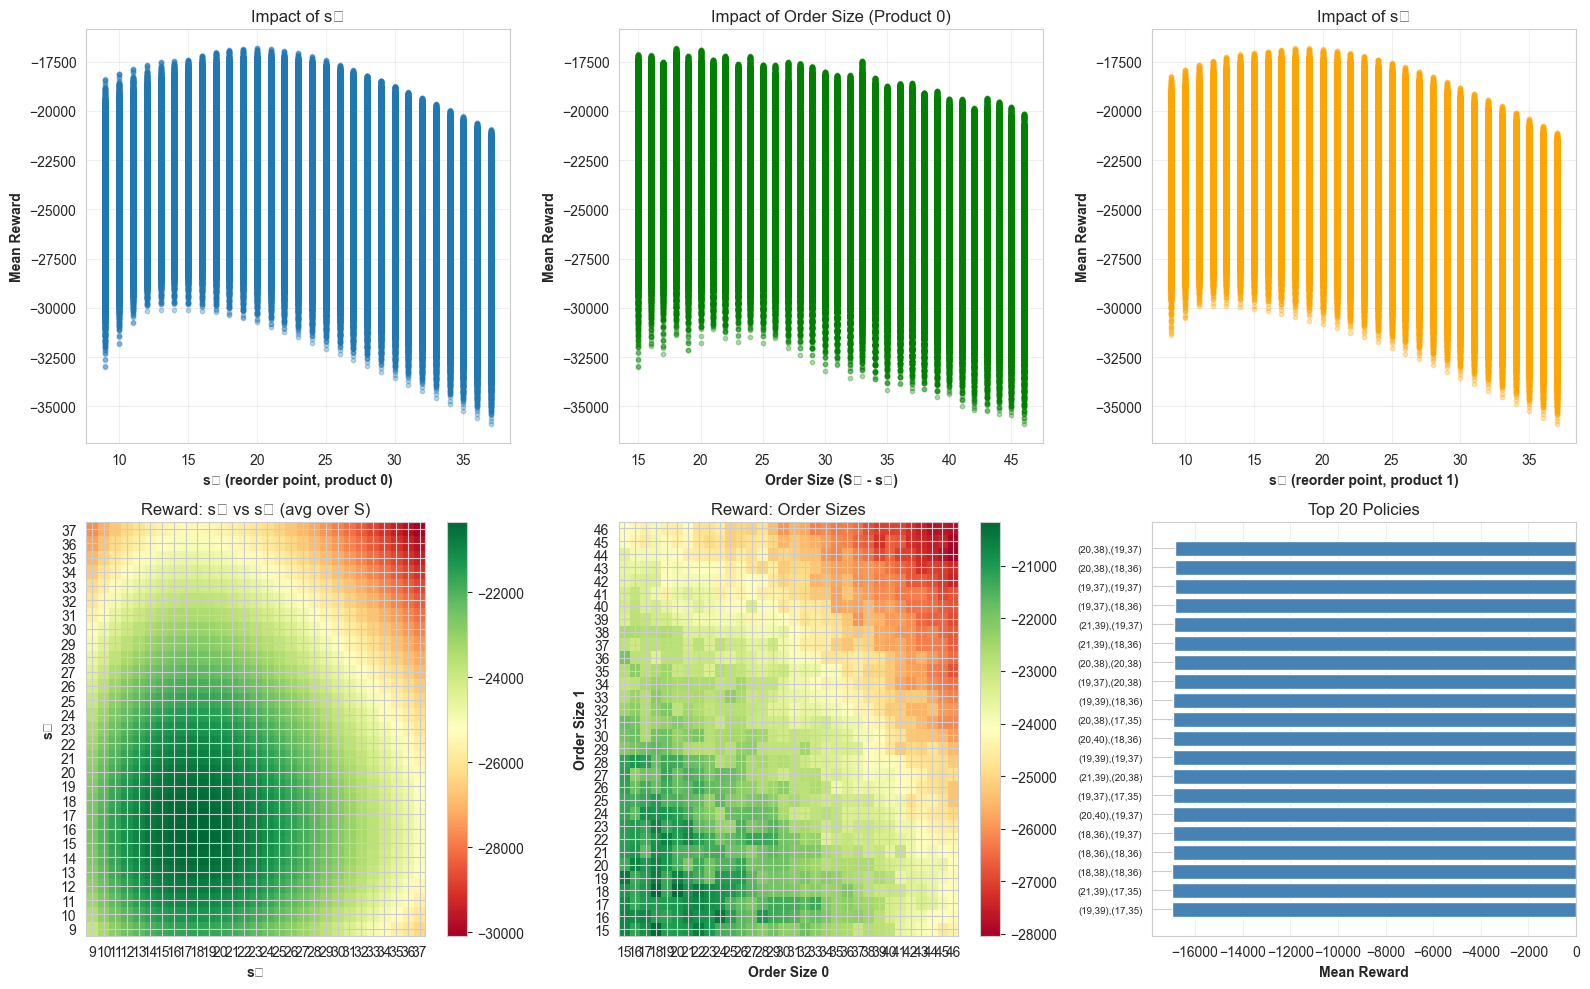


💡 Insights from visualizations:
  - Identify optimal ranges for s and S
  - See how order sizes affect performance
  - Check for interactions between products


In [8]:
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# 1. Reward vs s0
axes[0, 0].scatter(full_results["s0"], full_results["mean_reward"], alpha=0.3, s=10)
axes[0, 0].set_xlabel("s₀ (reorder point, product 0)", fontweight="bold")
axes[0, 0].set_ylabel("Mean Reward", fontweight="bold")
axes[0, 0].set_title("Impact of s₀")
axes[0, 0].grid(alpha=0.3)

# 2. Reward vs order_size_0
axes[0, 1].scatter(
    full_results["order_size_0"],
    full_results["mean_reward"],
    alpha=0.3,
    s=10,
    color="green",
)
axes[0, 1].set_xlabel("Order Size (S₀ - s₀)", fontweight="bold")
axes[0, 1].set_ylabel("Mean Reward", fontweight="bold")
axes[0, 1].set_title("Impact of Order Size (Product 0)")
axes[0, 1].grid(alpha=0.3)

# 3. Reward vs s1
axes[0, 2].scatter(
    full_results["s1"], full_results["mean_reward"], alpha=0.3, s=10, color="orange"
)
axes[0, 2].set_xlabel("s₁ (reorder point, product 1)", fontweight="bold")
axes[0, 2].set_ylabel("Mean Reward", fontweight="bold")
axes[0, 2].set_title("Impact of s₁")
axes[0, 2].grid(alpha=0.3)

# 4. Heatmap: s0 vs s1 (average over S values)
pivot = full_results.groupby(["s0", "s1"])["mean_reward"].mean().reset_index()
heatmap_data = pivot.pivot(index="s1", columns="s0", values="mean_reward")
im1 = axes[1, 0].imshow(heatmap_data, cmap="RdYlGn", aspect="auto", origin="lower")
axes[1, 0].set_xlabel("s₀", fontweight="bold")
axes[1, 0].set_ylabel("s₁", fontweight="bold")
axes[1, 0].set_title("Reward: s₀ vs s₁ (avg over S)")
axes[1, 0].set_xticks(range(len(heatmap_data.columns)))
axes[1, 0].set_xticklabels(heatmap_data.columns)
axes[1, 0].set_yticks(range(len(heatmap_data.index)))
axes[1, 0].set_yticklabels(heatmap_data.index)
plt.colorbar(im1, ax=axes[1, 0])

# 5. Heatmap: order_size_0 vs order_size_1
pivot2 = (
    full_results.groupby(["order_size_0", "order_size_1"])["mean_reward"]
    .mean()
    .reset_index()
)
heatmap_data2 = pivot2.pivot(
    index="order_size_1", columns="order_size_0", values="mean_reward"
)
im2 = axes[1, 1].imshow(heatmap_data2, cmap="RdYlGn", aspect="auto", origin="lower")
axes[1, 1].set_xlabel("Order Size 0", fontweight="bold")
axes[1, 1].set_ylabel("Order Size 1", fontweight="bold")
axes[1, 1].set_title("Reward: Order Sizes")
axes[1, 1].set_xticks(range(len(heatmap_data2.columns)))
axes[1, 1].set_xticklabels(heatmap_data2.columns)
axes[1, 1].set_yticks(range(len(heatmap_data2.index)))
axes[1, 1].set_yticklabels(heatmap_data2.index)
plt.colorbar(im2, ax=axes[1, 1])

# 6. Top 20 policies
top20 = full_results.head(20).copy()
top20["policy"] = top20.apply(
    lambda x: f"({int(x['s0'])},{int(x['S0'])}),({int(x['s1'])},{int(x['S1'])})", axis=1
)
axes[1, 2].barh(range(len(top20)), top20["mean_reward"], color="steelblue")
axes[1, 2].set_yticks(range(len(top20)))
axes[1, 2].set_yticklabels(top20["policy"], fontsize=7)
axes[1, 2].set_xlabel("Mean Reward", fontweight="bold")
axes[1, 2].set_title("Top 20 Policies")
axes[1, 2].grid(axis="x", alpha=0.3)
axes[1, 2].invert_yaxis()

plt.tight_layout()
plt.show()

print("\n💡 Insights from visualizations:")
print("  - Identify optimal ranges for s and S")
print("  - See how order sizes affect performance")
print("  - Check for interactions between products")

## Part 7: Determine Q_max for RL Agent

The baseline (s,S) policy orders exactly (S - IP) units, which can vary.

**For the RL agent**, we need to set Q_max based on:
1. Maximum orders observed in best policy
2. Add some margin for exploration

**Formula**: `Q_max = max(max_order_0, max_order_1) + margin`

In [9]:
best_policy = full_results.iloc[0]

# Get maximum orders observed
max_order_0 = int(best_policy["max_order_0"])
max_order_1 = int(best_policy["max_order_1"])

# Add margin (e.g., 10%) for RL exploration
margin = 0.1
recommended_Q_max_0 = int(np.ceil(max_order_0 * (1 + margin)))
recommended_Q_max_1 = int(np.ceil(max_order_1 * (1 + margin)))
recommended_Q_max = max(recommended_Q_max_0, recommended_Q_max_1)

print("=" * 70)
print("Q_MAX DETERMINATION FOR RL AGENT")
print("=" * 70)
print(f"\n📊 Best baseline policy:")
print(f"  Product 0: (s={int(best_policy['s0'])}, S={int(best_policy['S0'])})")
print(f"    Typical order size: {int(best_policy['order_size_0'])}")
print(f"    Max observed: {max_order_0}")
print(f"  Product 1: (s={int(best_policy['s1'])}, S={int(best_policy['S1'])})")
print(f"    Typical order size: {int(best_policy['order_size_1'])}")
print(f"    Max observed: {max_order_1}")

print(f"\n🎯 Recommended Q_max for RL:")
print(f"  With {int(margin*100)}% margin: {recommended_Q_max}")
print(f"\n💡 This gives the RL agent:")
print(f"  - Enough action space to match baseline")
print(f"  - Room for exploration and improvement")
print(
    f"  - Action space size: ({recommended_Q_max + 1})² = {(recommended_Q_max + 1)**2} discrete actions"
)
print("=" * 70)

Q_MAX DETERMINATION FOR RL AGENT

📊 Best baseline policy:
  Product 0: (s=20, S=38)
    Typical order size: 18
    Max observed: 38
  Product 1: (s=19, S=37)
    Typical order size: 18
    Max observed: 37

🎯 Recommended Q_max for RL:
  With 10% margin: 42

💡 This gives the RL agent:
  - Enough action space to match baseline
  - Room for exploration and improvement
  - Action space size: (43)² = 1849 discrete actions


## Part 8: Initial State Strategy

Two approaches for episode initialization:

### Option A: Cold Start (Empty State)
- **State**: (0, 0, 0, 0) - no inventory, no orders

### Option B: Warm Start (Near Steady State)
- Find approximate steady-state, add randomness ±5

In [ ]:
def find_steady_state(
    policy: sSPolicy,
    num_episodes: int,
    episode_length: int,
    warmup_steps: int,
    random_seed: int,
) -> Tuple[float, float]:
    """
    Find approximate steady-state inventory levels by running policy.

    Args:
        policy: The (s,S) policy
        num_episodes: Number of long episodes to run
        episode_length: Steps per episode
        warmup_steps: Ignore first N steps (warmup period)
        random_seed: Random seed for reproducibility

    Returns:
        (mean_inv_0, mean_inv_1) averaged over steady-state period
    """
    master_rng = np.random.default_rng(random_seed)

    all_inventories_0 = []
    all_inventories_1 = []

    for ep in range(num_episodes):
        episode_rng = np.random.default_rng(master_rng.integers(0, 2**31))
        sim = InventorySimulation(random_state=episode_rng)
        sim.reset(initial_state=create_state(0, 0, 0, 0))

        for step in range(episode_length):
            current_state = sim.get_current_state()
            action = policy(current_state)
            next_state, info = sim.execute_daily_decision(action)

            # After warmup, record inventory levels
            if step >= warmup_steps:
                all_inventories_0.append(current_state.net_inventory[0])
                all_inventories_1.append(current_state.net_inventory[1])

    return np.mean(all_inventories_0), np.mean(all_inventories_1)  # type: ignore


# Find steady state for best policy
best_s0 = int(best_policy["s0"])
best_S0 = int(best_policy["S0"])
best_s1 = int(best_policy["s1"])
best_S1 = int(best_policy["S1"])

best_policy_obj = sSPolicy(params=((best_s0, best_S0), (best_s1, best_S1)))

print("Finding steady-state inventory levels...")
print(f"(Running policy for 10 long episodes with seed {SEEDS['steady_state']}...)\n")

ss_inv_0, ss_inv_1 = find_steady_state(
    best_policy_obj,
    num_episodes=10,
    episode_length=500,
    warmup_steps=200,
    random_seed=SEEDS["steady_state"],
)

print("=" * 70)
print("STEADY-STATE ANALYSIS")
print("=" * 70)
print(f"\n📊 Approximate steady-state inventory:")
print(f"    Product 0: {ss_inv_0:.1f} units")
print(f"    Product 1: {ss_inv_1:.1f} units")

print(f"\n📋 Compare with policy parameters:")
print(
    f"    Product 0: s={best_s0}, S={best_S0} → Operating range [{best_s0+1}, {best_S0}]"
)
print(
    f"    Product 1: s={best_s1}, S={best_S1} → Operating range [{best_s1+1}, {best_S1}]"
)

# Warm start recommendations
warm_start_range_0 = (max(0, int(ss_inv_0) - 5), int(ss_inv_0) + 5)
warm_start_range_1 = (max(0, int(ss_inv_1) - 5), int(ss_inv_1) + 5)

print(f"\n🎲 Warm-start ranges (if needed):")
print(f"    Product 0: [{warm_start_range_0[0]}, {warm_start_range_0[1]}]")
print(f"    Product 1: [{warm_start_range_1[0]}, {warm_start_range_1[1]}]")
print("=" * 70)

Finding steady-state inventory levels...
(Running policy for 10 long episodes...)

STEADY-STATE ANALYSIS

📊 Approximate steady-state inventory:
    Product 0: 11.9 units
    Product 1: 13.3 units

📋 Compare with policy parameters:
    Product 0: s=20, S=38 → Operating range [21, 38]
    Product 1: s=19, S=37 → Operating range [20, 37]

🎲 Warm-start ranges (if needed):
    Product 0: [6, 16]
    Product 1: [8, 18]


In [ ]:
# Compare initialization strategies
print("Comparing initialization strategies...\n")

# Use dedicated evaluation seed
eval_seed = SEEDS["evaluation"]

# Cold start
cold_results = evaluate_policy(
    best_policy_obj,
    num_episodes=20,
    episode_length=365,
    initial_state=(0, 0, 0, 0),
    random_seed=eval_seed,
)

# Warm start (near steady state)
warm_state = (int(ss_inv_0), int(ss_inv_1), 0, 0)
warm_results = evaluate_policy(
    best_policy_obj,
    num_episodes=20,
    episode_length=365,
    initial_state=warm_state,
    random_seed=eval_seed,
)

# Very warm start (at S)
very_warm_state = (best_S0, best_S1, 0, 0)
very_warm_results = evaluate_policy(
    best_policy_obj,
    num_episodes=20,
    episode_length=365,
    initial_state=very_warm_state,
    random_seed=eval_seed,
)

print("=" * 70)
print("INITIALIZATION STRATEGY COMPARISON")
print("=" * 70)
print(f"Evaluation seed: {eval_seed}\n")

strategies = [
    ("Cold Start (0,0,0,0)", cold_results),
    (f"Warm Start ({int(ss_inv_0)},{int(ss_inv_1)},0,0)", warm_results),
    (f"Very Warm (S₀={best_S0}, S₁={best_S1})", very_warm_results),
]

for name, results in strategies:
    print(f"\n  {name}")
    print(
        f"    Mean reward: {results['mean_reward']:.2f} ± {results['std_reward']:.2f}"
    )

print("\n💡 Note: All strategies evaluated with same seed for fair comparison")
print("=" * 70)

Comparing initialization strategies...

INITIALIZATION STRATEGY COMPARISON

  Cold Start (0,0,0,0)
    Mean reward: -16639.15 ± 1507.92

  Warm Start (11,13,0,0)
    Mean reward: -15170.35 ± 1165.50

  Very Warm (S₀=38, S₁=37)
    Mean reward: -15823.15 ± 1742.77


## Part 9: Save Final Configuration

In [ ]:
baseline_config = {
    "policy_type": "sS",
    "optimization_method": "grid_search_empirical",
    "seeds": {
        "grid_search": int(SEEDS["grid_search"]),
        "evaluation": int(SEEDS["evaluation"]),
        "steady_state": int(SEEDS["steady_state"]),
    },
    "search_space": {
        "s_range": [s_min, s_max],
        "S_offset_range": [order_size_min, order_size_max],
    },
    "evaluation": {
        "num_episodes": 10,
        "episode_length": 365,
        "initial_state": [0, 0, 0, 0],
        "initial_state_strategy": "cold_start",
    },
    "best_policy": {
        "product_0": {
            "s": int(best_policy["s0"]),
            "S": int(best_policy["S0"]),
            "typical_order_size": int(best_policy["order_size_0"]),
            "max_order_observed": int(best_policy["max_order_0"]),
        },
        "product_1": {
            "s": int(best_policy["s1"]),
            "S": int(best_policy["S1"]),
            "typical_order_size": int(best_policy["order_size_1"]),
            "max_order_observed": int(best_policy["max_order_1"]),
        },
    },
    "performance": {
        "mean_reward": float(best_policy["mean_reward"]),
        "std_reward": float(best_policy["std_reward"]),
    },
    "steady_state": {"inventory_0": float(ss_inv_0), "inventory_1": float(ss_inv_1)},
    "rl_agent_config": {
        "recommended_Q_max": recommended_Q_max,
        "action_space_size": (recommended_Q_max + 1) ** 2,
        "reasoning": "Based on max observed orders + 10% margin for exploration",
    },
}

# Save to file
with open("../../results/baseline_config_empirical.json", "w") as f:
    json.dump(baseline_config, f, indent=2)

print("=" * 70)
print("✅ BASELINE CONFIGURATION SAVED")
print("=" * 70)
print("\nFile: results/baseline_config_empirical.json")
print("\nKey parameters:")
print(
    f"  Best policy: P0=(s={int(best_policy['s0'])}, S={int(best_policy['S0'])}), "
    f"P1=(s={int(best_policy['s1'])}, S={int(best_policy['S1'])})"
)
print(
    f"  Baseline reward: {best_policy['mean_reward']:.2f} ± {best_policy['std_reward']:.2f}"
)
print(f"  Recommended Q_max for RL: {recommended_Q_max}")
print(f"  RL action space size: {(recommended_Q_max + 1)**2}")
print(f"\n🎲 Seeds used:")
for name, seed in SEEDS.items():
    print(f"    {name}: {seed}")
print("=" * 70)

✅ BASELINE CONFIGURATION SAVED

File: results/baseline_config_empirical.json

Key parameters:
  Best policy: P0=(s=20, S=38), P1=(s=19, S=37)
  Baseline reward: -16820.50 ± 1630.63
  Recommended Q_max for RL: 42
  RL action space size: 1849
